# Test: Iteratively find closest route between a centroid and multiple park access points returning only the shortest route for each park within max network service area distance

In this notebook let's see how we can iteratively calculate park access to see what it looks like to try and route from a single centroid to multiple access points like in the previous notebook. However, this notebook will go a step further by filtering out the shortest route to each distinct park. As it stands, parks with multiple access points return multiple distinct routes. We only care about the shortest route! This moves us closer to what the EBPA model will need to do - find the distance to Census Blocks within a given distance - so I want to see what the data look like when we do this. I will use the Automating GIS course [lesson on OSMNX](https://automating-gis-processes.github.io/2018/notebooks/L6/network-analysis.html) as a primary jumping off point.

## Libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas_bokeh
pandas_bokeh.output_notebook()
import pandas as pd

from shapely.geometry import LineString, Point

import contextily as ctx
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

Loading BokehJS ...

## Helper Functions and Variables

In [16]:
def plot_layer(gdf, basemap):
    """Quickly create a plot of a single GeoDataFrame
    
    Parameters:
    gdf (GeoDataFrame): A geopandas GeoDataFrame
    basemap (string): XYZ tile URL for Web Mercator tileset
    
    """
    ax = gdf.to_crs(epsg = 3857).plot(alpha = 0.5, figsize = (12, 12))
    ctx.add_basemap(ax = ax, url = basemap)
    
    return ax

# Basemaps
basemaps = {
    'dark': 'https://a.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png',
    'imagery': 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
}

## Load Data/Graphs

### Hexagons

For this test, Raleigh is split up into 241 regular hexagons. For this notebook, they'll largely be used for the final display rather than the actual analysis.

,hexid,geometry
0,100,"(POLYGON ((-78.8228393 35.8827112, -78.8155071..."
1,101,"(POLYGON ((-78.8227941 35.9033151, -78.81546 3..."
2,102,"(POLYGON ((-78.82274889999999 35.9239189, -78...."
3,103,"(POLYGON ((-78.8009893 35.8517712, -78.7936571..."
4,104,"(POLYGON ((-78.8008878 35.8929794, -78.7935518..."


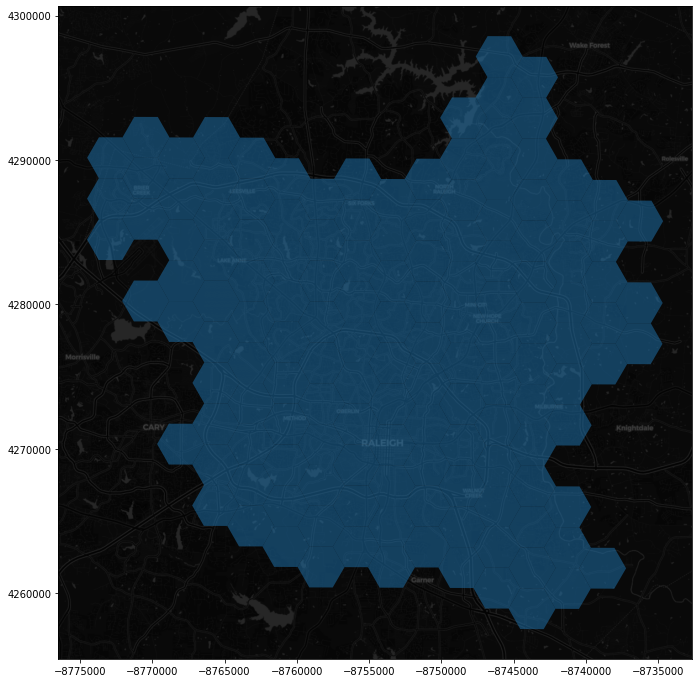

In [18]:
hex_gdf = gpd.read_file('./data/dummy_data/hexgrid_polygon_4326.geojson')
display(hex_gdf.head())
hex_plot = plot_layer(hex_gdf, basemaps['dark'])

### Origins: Hexagon Centroids

For our analysis, we need origin points for modeling residents' trips to a various parks along the road network. We can use the centroid of each of the 241 hexagons above as the origins.

,hexid,geometry
0,100,POINT (-78.80822189790321 35.88268912534678)
1,101,POINT (-78.80817295905025 35.9032930174214)
2,102,POINT (-78.80812400904843 35.9238967673457)
3,103,POINT (-78.78637745875685 35.85174651205295)
4,104,POINT (-78.78626847479518 35.89295464523266)


None

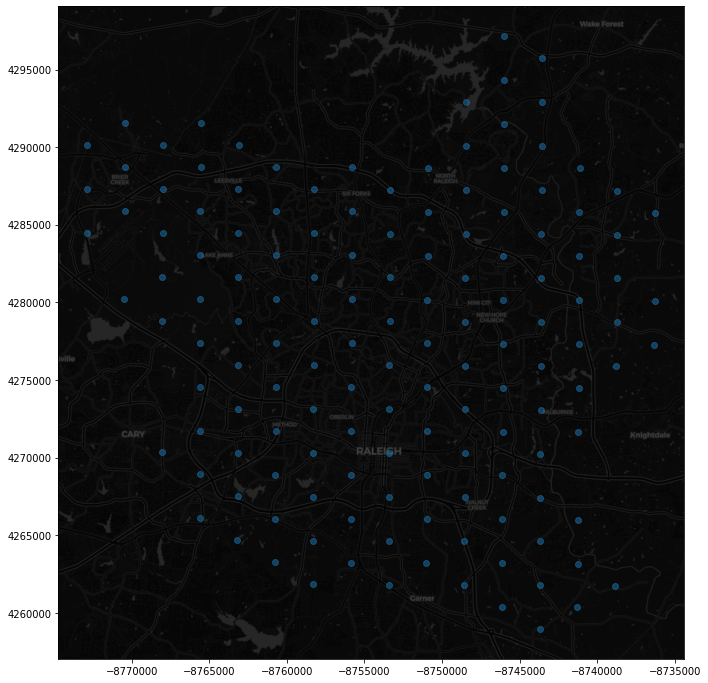

In [6]:
blocks_gdf = gpd.read_file('./data/dummy_data/hexgrid_point_4326.geojson')
display(blocks_gdf.head())
display(plot_layer(blocks_gdf, basemaps['dark']))

### Destinations: Park Access Points

We'll use park access points as destinations for the analysis

,OBJECTID,PARKID,TYPE,STATUS,ENTRANCE,PARK_NAME,NETWORK,AP_ID,AP_CODE,geometry
0,1,38,Pedestrian,Official,Park Greenway,Kiwanis,YES,Kiwanis - 001,38-001,POINT (-78.63257590000001 35.8194586)
1,2,16,Pedestrian,Official,Park Greenway,Chavis,YES,Chavis - 002,16-002,POINT (-78.6299628 35.7668947)
2,3,91,Pedestrian,Official,Park,Laurel Hills,YES,Laurel Hills - 001,91-001,POINT (-78.69497560000001 35.830622)
3,4,85,Pedestrian,Official,Park,Fred Fletcher,YES,Fred Fletcher - 001,85-001,POINT (-78.6499972 35.7939233)
4,5,84,Pedestrian,Official,Park Greenway,Brentwood,YES,Brentwood - 002,84-002,POINT (-78.59879650000001 35.830886)


None

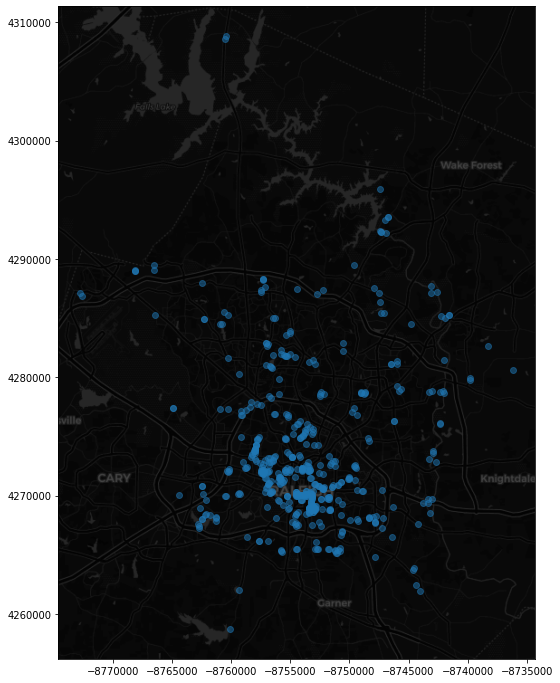

In [7]:
destinations_gdf = gpd.read_file('./data/dummy_data/park_access_4326.geojson')
display(destinations_gdf.head())
display(plot_layer(destinations_gdf, basemaps['dark']))

### Parks

Like the hexagons, we mostly need park boundaries for visulization purposes.

None

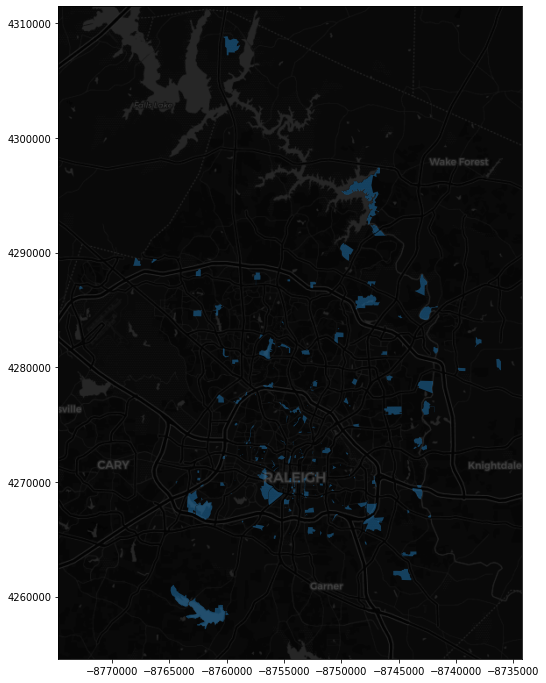

In [10]:
parks_gdf = gpd.read_file("https://opendata.arcgis.com/datasets/43b5d6bf9d6e400599498d052545d331_0.geojson")
display(plot_layer(parks_gdf, basemaps['dark']))

### Road Graph

We'll use OSMnx to load in a driving network of OSM data for Wake County, NC. This will give us a graph we can use to determine the network distance from each hexagon centroid to each park.

In [11]:
graph_proj = ox.load_graphml('raleigh_drive.graphml.gz')

In [ ]:
# USE THIS IF THERE'S NO LOCAL COPY OF OSM DATA
# hex_extent = hex_gdf.total_bounds

# graph = ox.graph_from_bbox(hex_extent[3], hex_extent[1], hex_extent[2], hex_extent[0], network_type="drive")
# graph_proj = ox.project_graph(graph, to_crs={'init':'epsg:2264'})

The network graph is not really a conventional spatial data format. OSMnx is a great tool for negotiating the network analyis with our interest in using the results of that analysis for more explicitly spatial analysis. It has functions that let us create a network graph from OSM data as well as a GeoDataFrame.

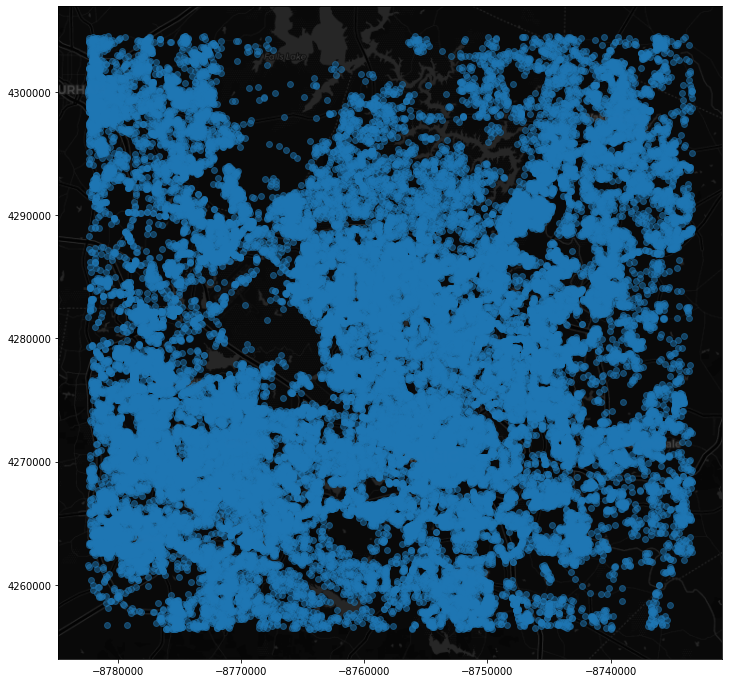

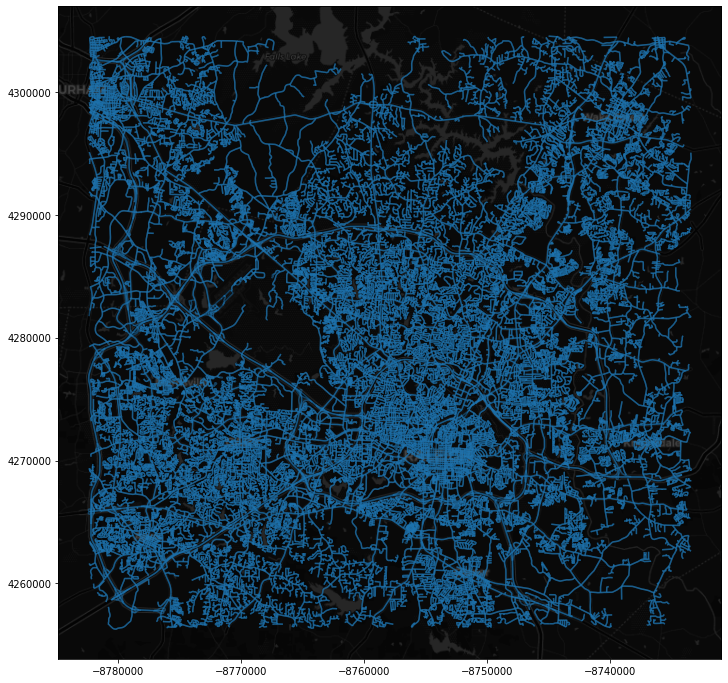

In [37]:
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)
display(plot_layer(nodes_proj, basemaps['dark']))
display(plot_layer(edges_proj, basemaps['dark']))


In [55]:
nodes_proj.head()

,highway,osmid,ref,x,y,lon,lat,geometry
195428353,nan,195428353,nan,2.043234e+06,721299.426476,-78.8543233,35.7317874,POINT (2043234.355075191 721299.4264761809)
195559426,nan,195559426,nan,2.069343e+06,702084.834094,-78.766504,35.678861,POINT (2069342.895857912 702084.8340940218)
195428358,nan,195428358,nan,2.042322e+06,721722.730476,-78.857396,35.732954,POINT (2042321.820869853 721722.7304764584)
195559432,nan,195559432,nan,2.069723e+06,702921.545147,-78.765218,35.6811573,POINT (2069722.830554804 702921.5451469965)
1283325961,nan,1283325961,nan,2.157544e+06,717295.764034,-78.469236,35.719718,POINT (2157544.479308429 717295.7640337365)


## Data Preporcessing

### Reproject data layers

In [ ]:
hex_proj_gdf = hex_gdf.to_crs({'init':'epsg:2264'})
blocks_proj_gdf = blocks_gdf.to_crs({'init':'epsg:2264'})
destinations_proj_gdf = destinations_gdf.to_crs({'init':'epsg:2264'})

## Get Destination nodes for all access points

Very rarely do the locations we're interested analyzing in a network correspond with an actual node in the network. As such, we need to assign each park access point to its nearest node on the network. 

In [ ]:
%%time
destinations_proj_gdf['nearest_node'] = destinations_proj_gdf.apply(lambda row: ox.get_nearest_node(graph_proj, (row['geometry'].y, row['geometry'].x), method = "euclidean"), axis=1)
display(destinations_proj_gdf.head())

## Get Origin nodes for all blocks

Similarly to our park access points, we also need to find the nearest node in our network graph for each hexagon centroid.

In [ ]:
%%time
blocks_proj_gdf['nearest_node'] = blocks_proj_gdf.apply(lambda row: ox.get_nearest_node(graph_proj, (row['geometry'].y, row['geometry'].x), method = "euclidean"), axis=1)
display(blocks_proj_gdf.head())

## Get Destinations w/in 4-miles of the origin for all blocks

We want to iterate through each block, find the shortest route to parks within 4 miles, and add the resulting gdf to a list.

First, we'll create an empty list to hold the results of our iterations.

In [ ]:
block_routes_list = []
# Generate a list of GeoDataFrames of the routes to parks for each hexagon. Add to block_routes_list
for o_idx, o_row in blocks_proj_gdf.iterrows():
    print(o_row["hexid"])
    origin_max_service_area = o_row['geometry'].centroid.buffer(5280*4)
    destinations_select = destinations_proj_gdf[destinations_proj_gdf.intersects(origin_max_service_area)]
    
    
    route_list = []
    # Add each route and associated attribute info for each hexagon to park route 
    for d_idx, d_row in destinations_select.iterrows():
        try:
            route = nx.shortest_path(G=graph_proj, source = o_row["nearest_node"], target = d_row["nearest_node"], weight = "length")
        except nx.NetworkXNoPath:
            print("No path connecting origin node, {}, and destination node, {}.".format(o_row["nearest_node"], d_row["nearest_node"]))
            nodes_list = list(graph_proj.nodes)
            nodes_list.remove(d_row["nearest_node"])
            subgraph_proj = ox.induce_subgraph(graph_proj, nodes_list)
            # get new nearest node for d_row
            new_d_node = ox.get_nearest_node(subgraph_proj, (d_row['geometry'].y, d_row['geometry'].x), method = "euclidean")
            print("New nearest destination node = {}".format(new_d_node))
            # get shortest path between o_row and new d_row node
            route = nx.shortest_path(G=graph_proj, source = o_row["nearest_node"], target = new_d_node, weight = "length")
        finally:
            route_nodes = nodes_proj.loc[route]

            if o_row["nearest_node"] != d_row["nearest_node"]:
                route_line = LineString(list(route_nodes.geometry.values))
            else:
                print(o_row["nearest_node"])
                print(route_nodes)
                route_line = LineString([route_nodes.geometry.values[0], route_nodes.geometry.values[0]])
            route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs={'init':'epsg:2264'}, columns=['geometry'])
            route_geom['length_ft'] = route_geom.length
            route_geom['origin_id'] = o_row["hexid"]
            route_geom['parkid'] = d_row['PARKID']
            route_geom['park_name'] = d_row['PARK_NAME']
            route_geom['ap_code'] = d_row['AP_CODE']
            route_list.append(route_geom)
        
    block_routes_list.append(gpd.GeoDataFrame(pd.concat(route_list)))
    
# Combine all the routes for each hexagon into a single GeoDataFrame
block_routes_gdf = gpd.GeoDataFrame(pd.concat(block_routes_list), geometry='geometry', crs={'init':'epsg:2264'})
block_routes_4326_gdf = block_routes_gdf.to_crs({'init': 'epsg:4326'})

Remember that we've only calculated the shortest path from each hexagon to each park access point within 4 miles of the hexagon centroid. Since many parks have multiple access points, we need to reduce `block_routes_4326_gdf` to only show the shortest path between each hexagon and park. 

In [ ]:
block_routes_4326_shortest_df = block_routes_4326_gdf.sort_values('length_ft').groupby(['origin_id','parkid'], as_index=False).first()
block_routes_4326_shortest_gdf = gpd.GeoDataFrame(block_routes_4326_shortest_df, geometry='geometry', crs={'init':'epsg:4326'})
block_routes_4326_shortest_gdf.head()

## Examine Results

Input a number between 1 and 141 to view park accessibility for each hexagon.

In [ ]:
@interact_manual
def plot_routes(hex = widgets.BoundedIntText(
    value = 100,
    min = 100,
    max = 241,
#     step = 1,
#     options = range(100, 242),
    description = "Block: "
)):
    fig = hex_gdf.plot_bokeh(
        figsize = (1200, 800),
        tile_provider_url = "https://a.basemaps.cartocdn.com/dark_all/{Z}/{X}/{Y}{R}.png",
        fill_alpha = 0,
        line_color = "white",
        line_alpha = 0.25,
        legend = "Blocks",
        show_figure = False,
        hovertool_columns = ["hexid"]
    )
    
    # Filter the selected hexagon
    hex_select_gdf = hex_gdf.loc[hex_gdf["hexid"] == hex]
    # Filter routes for selected hexagon
    block_routes_select_all_gdf = block_routes_4326_shortest_gdf.loc[block_routes_4326_shortest_gdf["origin_id"] == hex]
    # Get shortest route between selected hexagon and a park that are shorter than 4 miles
    block_routes_select_shortest_nsa_gdf = block_routes_select_all_gdf.loc[block_routes_select_all_gdf['length_ft'] <= 4*5280]
    # Get the shortest route between the selected hexagon and a park
    nsa_shortest_route = block_routes_select_shortest_nsa_gdf.loc[block_routes_select_shortest_nsa_gdf['length_ft'] == block_routes_select_shortest_nsa_gdf['length_ft'].min()]
    # Get only the parks that are accessible within 4 miles of the selected hexagon
    parks_select_gdf = parks_gdf.loc[parks_gdf["PARKID"].isin(block_routes_select_shortest_nsa_gdf["parkid"].unique())]
        
    hex_parks_list = []

    return [hex_select_gdf.plot_bokeh(
        figure = fig,
        fill_alpha = 0.25,
        color = "#18FFFF",
        tile_provider = None,
        line_width = 0,
        show_figure = False,
        legend = "Selected Block"
    ), parks_select_gdf.plot_bokeh(
        figure = fig,
        tile_provider = None,
        color = "red",
        alpha = 0.35,
        legend = "Parks",
        hovertool_columns = ["NAME"],
        show_figure = False
    ), block_routes_select_shortest_nsa_gdf.plot_bokeh(
        figure = fig,
        tile_provider = None,
        color = "#18FFFF",
        alpha = 0.75,
        legend = "Routes",
        show_figure = False
    ), nsa_shortest_route.plot_bokeh(
        figure = fig,
        tile_provider = None,
        color = "#9C27B0",
        alpha = 1,
        line_width = 2,
        legend = "Shortest Route"
    ), display(parks_select_gdf)]